### Importing the required libraries

Situation: Using the CNN's I am trying to do a classification. 

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score 
from torchsummary import summary

Model


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
#Declaring the transform for each image (Convert to Tensor and Normalize)
toTensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0), (1.0))
])


In [ ]:
#Declaring a CustomDataset class
class CustomDataset(Dataset):
    #Based on the root directory address shuffling the images in each folder and loading 1000 from each class folder.
    def __init__(self, rootDir, num_images_per_class, toTensor):
        self.dataset_dir = rootDir
        self.num_images_per_class = num_images_per_class
        self.imagePaths = []
        self.labels = []
        self.toTensor = toTensor
        self.classesName = ["Hand", "BreastMRI", "ChestCT", "HeadCT", "AbdomenCT", "CXR" ]
        class_folders = os.listdir(rootDir)
        #loop to load over class folders
        for label, classFolder in enumerate(class_folders):
            classPath = os.path.join(rootDir, classFolder)
            imageFiles = os.listdir(classPath)
            random.shuffle(imageFiles)

            #Creating the path for images in individual class folders
            for i in range(num_images_per_class):
                imagePath = os.path.join(classPath, imageFiles[i])
                self.imagePaths.append(imagePath)
                self.labels.append(label)

    #method to read the images based on the path created above using os library.
    def __getitem__(self, index):
        imagePath = self.imagePaths[index]
        label = self.labels[index]
        image1 = cv2.imread(imagePath) #Reading in the image using OPENCV LIB.
        image2 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image =  self.toTensor(image1) #Using totensor created above to transform each image
        label = torch.tensor(label) 
        return image, label

    def __len__(self):
        return len(self.imagePaths)

    #Creating a method to display a image from each class.
    def display(self):
        fig, axes = plt.subplots(nrows=len(set(self.labels)), ncols=1, figsize=(6, 10))
        for label in range(len(set(self.labels))):
            # Select a random image from the current class
            indices = np.where(np.array(self.labels) == label)[0]
            index = np.random.choice(indices)
            
            # Load and display the image
            imagePath = self.imagePaths[index]
            image1 = cv2.imread(imagePath)
            image2 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
            axes[label].imshow(image2)
            axes[label].set_title(f"Class {self.classesName[label]}")
            axes[label].axis("off")

        #Plotting the images    
        plt.tight_layout()
        plt.show()


In [ ]:
#Declaring the Root directory to get the MNIst dataset from google drive
rootDir = '/content/drive/MyDrive/BMED/MedNIST_dataset'

#Creating a Class Object of CustomDataset
Dataset = CustomDataset(rootDir, 1000, toTensor)

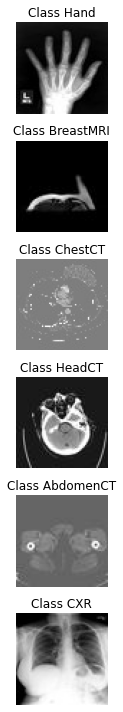

In [ ]:
#Displaying the Images
Dataset.display()

In [ ]:
#Using randomSplit spliting the dataset into train and test
trainData, testData = random_split(Dataset, [4200, 1800])

#Declaring hyper-parameters
numClasses = 6
learningRate = 0.001
numEpochs = 10
batchSize = 16

In [ ]:
#Declaring the Dataloaders for train and test.
trainDataLoader = DataLoader(trainData, batch_size = batchSize,  shuffle = True)
testDataLoader = DataLoader(testData, batch_size = batchSize,  shuffle = True)

1(B)

In [ ]:
#Declaring Custom Network based on the instructions
class CustomNetwork(torch.nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) #Conv Layer
        self.relu1 = nn.ReLU() #Relu Layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #MaxPool layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) #Conv layer
        self.relu2 = nn.ReLU() #Relu Layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  #MaxPool layer
        self.fc1 = nn.LazyLinear(128) #FC Layer
        self.relu3 = nn.ReLU() #Relu Layer
        self.fc2 = nn.LazyLinear(64) #FC Layer
        self.relu4 = nn.ReLU() #Relu Layer
        self.fc3 = nn.LazyLinear(6) #FC Layer
        self.softmax = nn.Softmax(dim=1) #Softmax to calcuate the probabilities

    def forward(self, inputImage):
        #Creating the network forward method
        x = self.conv1(inputImage)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [ ]:
#Declaring the model object from created custom network class
model = CustomNetwork()
print(model) #Priting the model

CustomNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): LazyLinear(in_features=0, out_features=64, bias=True)
  (relu4): ReLU()
  (fc3): LazyLinear(in_features=0, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


1(C)

In [ ]:
# Define the model, loss function, and optimizer
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)

best_val_loss = float('inf')
best_val_acc = 0.0

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(numEpochs):
    train_loss = 0.0
    total = 0
    correct = 0
    y_true = []
    y_pred = []
    model.train()
    for i, (images, labels) in enumerate(trainDataLoader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy and F1 score
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        y_true += labels.tolist()
        y_pred += predicted.tolist()        
        train_loss += loss.item()
        
        
    train_loss = train_loss / len(trainData)
    train_acc = 100 * correct / total
    train_loss_list.append(train_loss) # Calculating the Train loss
    train_acc_list.append(train_acc) # Calculating the Train Accuracy
    print(f"Epoch:{epoch}; train_acc:{train_acc}; train_loss{train_loss}")

    # Evaluate model on test set
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        total = 0
        correct = 0
        y_true = []
        y_pred = []
        for images, labels in testDataLoader:            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate accuracy and F1 score
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item() #Calculating the no.of correct o/ps
            y_true += labels.tolist()
            y_pred += predicted.tolist()
            test_loss += loss.item()
        
        test_loss = test_loss / len(testData) #Calculating the Test loss
        test_acc = 100 * correct / total #Calculating the Test Accuracy
        print(f"Epoch:{epoch}; test_acc:{test_acc}; test_loss{test_loss}")


Epoch:0; train_acc:66.83333333333333; train_loss0.08604626292274112
Epoch:0; test_acc:60.72222222222222; test_loss0.09014746540122562
Epoch:1; train_acc:67.28571428571429; train_loss0.08578507982549213
Epoch:1; test_acc:81.0; test_loss0.07737149000167846
Epoch:2; train_acc:81.30952380952381; train_loss0.07706728841577258
Epoch:2; test_acc:82.11111111111111; test_loss0.07677015331056383
Epoch:3; train_acc:83.04761904761905; train_loss0.07593627574897947
Epoch:3; test_acc:98.88888888888889; test_loss0.06634358108043671
Epoch:4; train_acc:98.11904761904762; train_loss0.06658242574759891
Epoch:4; test_acc:99.27777777777777; test_loss0.06603068749109904
Epoch:5; train_acc:99.02380952380952; train_loss0.06600901686009907
Epoch:5; test_acc:99.27777777777777; test_loss0.06599718146853976
Epoch:6; train_acc:99.5; train_loss0.06567916699818202
Epoch:6; test_acc:99.77777777777777; test_loss0.06570289923085107
Epoch:7; train_acc:98.92857142857143; train_loss0.06601092366945176
Epoch:7; test_acc:99

1(D) Plotting the train and test loss below using matplot

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(numEpochs), train_loss_list, label='Training loss')
plt.plot(range(numEpochs), test_loss_list, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

81.0


Calculating the metrics from the outputs obtained from the model output.

In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
test_acc_list.append(test_acc)
test_loss_list.append(test_loss)        
print('Confusion matrix:', conf_mat)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)